In [166]:
#### detect hardware
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()
##################################

Mounted at /content/drive/
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10189252870423387882
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 42694639371734120
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [167]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision
from skimage import io, transform
from PIL import Image
from torchvision import transforms
import cv2

import matplotlib.pyplot as plt

In [338]:
root = '/content/drive/MyDrive/satImagePrediction/'

labelsFile = root + 'Areal_label.name' 


trainFeaturesFile = root + 'Areal_train.data'
valFeaturesFile = root + 'Areal_valid.data'
testFeaturesFile = root + 'Areal_test.data'

allLabelsFile   = root + 'Areal_train.solution'

height, width , channels = 128,128,3  

In [339]:
###load labels names
labelNames = []

with open(labelsFile) as f:
  data = f.readlines()
  labelNames = [x.strip() for x in data]

print(labelNames)

['beach', 'chaparral', 'cloud', 'desert', 'forest', 'island', 'lake', 'meadow', 'mountain', 'river', 'sea', 'snowberg', 'wetland']


[5 0 0 ... 1 7 1]


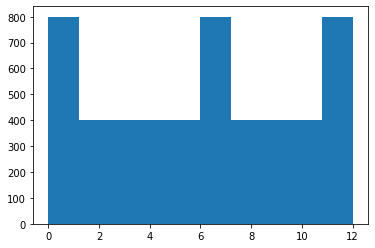

In [340]:
#### load target classes 
y = []

with open(allLabelsFile) as f:
  data = f.readlines()
  y = np.array([int(x.strip()) for x in data])

print(y)
plt.hist(y)
plt.show()

In [342]:
#### load train data
from math import pow
xTrain = []
trans = transforms.Grayscale(num_output_channels=1)
with open(trainFeaturesFile) as f:

  data = f.readlines()
  k = 1

  for d in data:
    d = d.strip()
    d = [int(x) for x in d.split(' ')]
    image = np.array(d).reshape((height, width , channels)).astype(np.uint8)
    #grayscale = np.expand_dims(np.array(trans(Image.fromarray(image))), axis=2)

    #plt.subplot(4,4,k)
    #k += 1
    #plt.imshow(np.squeeze(grayscale))
    #plt.subplot(4,4,k)
    #k += 1 
    #plt.imshow(image)
    '''

    brightest = grayscale.max()
    threshold = brightest // 2
    binary = np.where(grayscale > threshold, 255, 0)

    #plt.subplot(4,4,k)
    #k += 1
    #plt.imshow(np.squeeze(binary))

    vdvi = np.zeros((image.shape[0], image.shape[1]))

    #R=0 , G=1, B=2
    #a = 0.667
    for x in range(image.shape[0]):
      for t in range(image.shape[1]):
        vdvi[x,t] = (2*image[x,t,1] - image[x,t,0] - image[x,t,2]) / (2*image[x,t,1] + image[x,t,0] + image[x,t,2])

    #plt.subplot(4,4,k)
    #k += 1
    #plt.imshow(vdvi)
    '''
    xTrain.append(image/255.0)


xTrain = np.array(xTrain)

In [343]:
print(xTrain.shape)

(5200, 128, 128, 3)


In [344]:
from sklearn.model_selection import train_test_split

xTrain, xVal, yTrain, yVal = train_test_split(xTrain, y, test_size=0.2, random_state=777)

In [345]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)
print(y.shape)




(4160, 128, 128, 3)
(4160,)
(1040, 128, 128, 3)
(1040,)
(5200,)


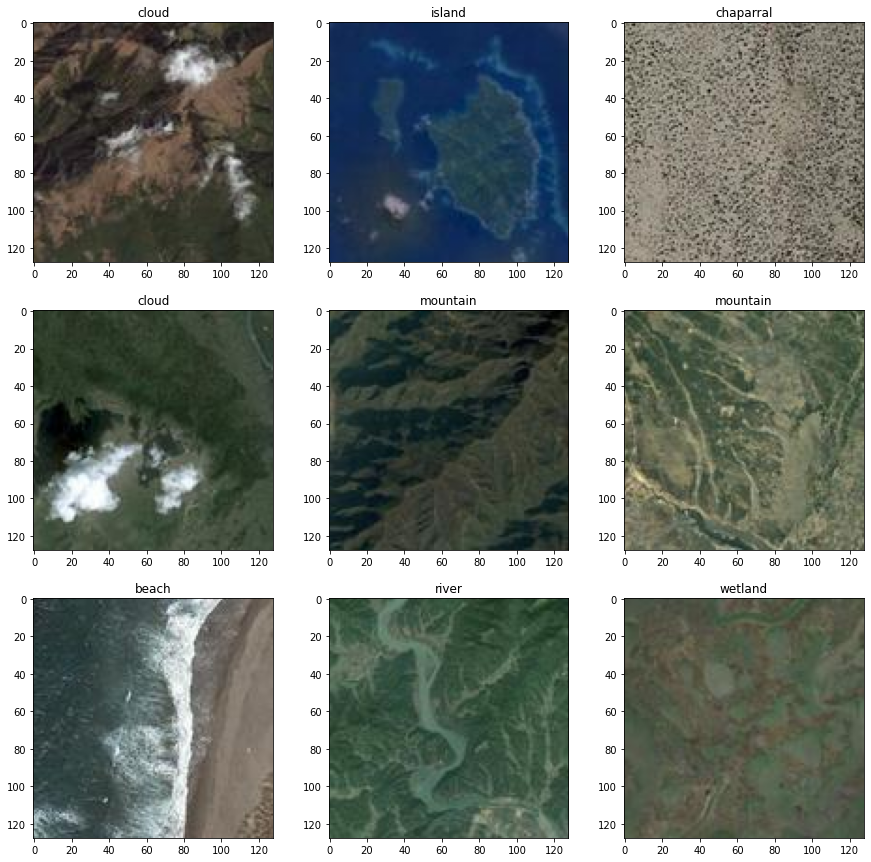

In [346]:
### sample some images and their labels

fig = plt.figure(figsize=(15,15))

for k in range(1,10):
  idx = np.random.randint(0,len(xTrain))

  plt.subplot(3,3,k)
  plt.imshow(np.squeeze(xTrain[idx]))
  plt.title(labelNames[yTrain[idx]])

plt.show()

In [347]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#### data augumentation
from tensorflow.keras.utils import to_categorical

datagen = ImageDataGenerator()

In [ ]:
datagen.fit(xTrain)

ValueError: ignored

In [ ]:
t = datagen.flow(xTrain, yTrain, batch_size=32)
s = t.next()

fig = plt.figure(figsize=(15,15))

for k in range(1,10):
  plt.subplot(3,3,k)
  plt.imshow(s[0][k]/255.0)
  plt.title(labelNames[s[1][k]])

plt.show()

ValueError: ignored

In [366]:
### define model
### effNet B6 - 43mil param
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, Flatten, MaxPool2D


inputs = Input(shape=(height, width, 3))

x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
 
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
 
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
 
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(13, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
optimizer = tf.keras.optimizers.SGD(lr=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()


#### callbacks
'''
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
'''

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_409 (Conv2D)          (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_265 (MaxPoolin (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_194 (Dropout)        (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_410 (Conv2D)          (None, 63, 63, 32)        9248      
_________________________________________________________________
conv2d_411 (Conv2D)          (None, 61, 61, 32)        924

'\ntensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")\ncheckpoint_filepath = \'./checkpoint\'\nmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath=checkpoint_filepath,\n    save_weights_only=True,\n    monitor=\'val_acc\',\n    mode=\'max\',\n    save_best_only=True)\n'

In [ ]:
!pip install keras-lr-finder

Epoch 1/5
130/130 [==============================] - 4s 28ms/step - loss: 2.5668 - accuracy: 0.0760
Epoch 2/5
130/130 [==============================] - 4s 29ms/step - loss: 2.5672 - accuracy: 0.0686
Epoch 3/5
130/130 [==============================] - 4s 28ms/step - loss: 2.5662 - accuracy: 0.0845
Epoch 4/5
130/130 [==============================] - 4s 29ms/step - loss: 2.5591 - accuracy: 0.0902
Epoch 5/5
130/130 [==============================] - 4s 28ms/step - loss: 2.5744 - accuracy: 0.0791


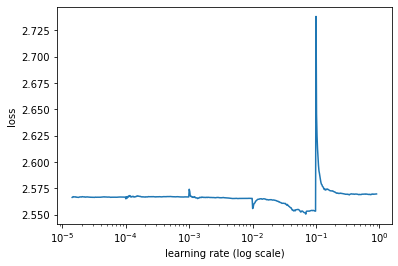

In [367]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)

lr_finder.find(xTrain, to_categorical(yTrain, num_classes=13), start_lr=0.00001, end_lr=1, batch_size=32, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [1]:
history = model.fit(xTrain, to_categorical(yTrain, num_classes=13),
                    validation_data = (xVal, to_categorical(yVal, num_classes=13)),
                    epochs=100)

NameError: ignored

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

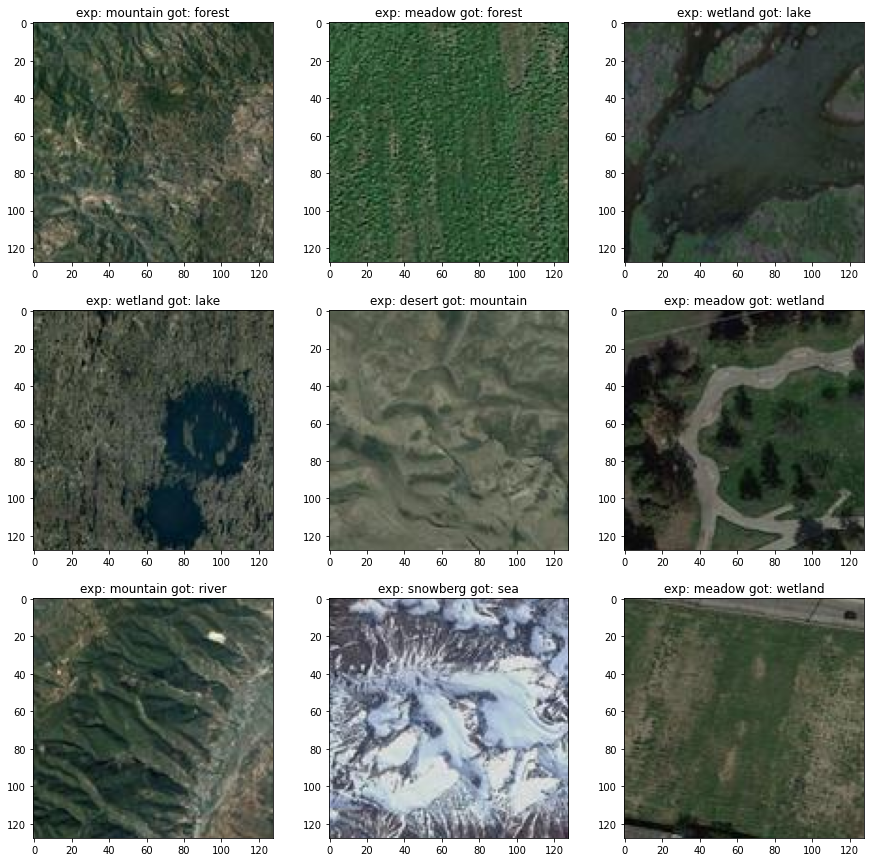

In [ ]:
### test results
fig = plt.figure(figsize=(15,15))
k = 1
for p in range(len(xVal)):
  input = xVal[p].reshape((1, width, height, channels))
  output = model.predict(input)
  res = np.argmax(output)
  if (res != yVal[p]) and k < 10:
    plt.subplot(3,3,k)
    plt.imshow(xVal[p])
    plt.title("exp: " + labelNames[yVal[p]] + " got: " + labelNames[res])
    k += 1
plt.show()


  

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
y_true = []
y_pred = []

counter = 0 
for idx in range(len(xVal)):
  res = model.predict(xVal[idx].reshape((1, width, height, 3)), batch_size=1)
  counter += 1

  y_true.append(yVal[idx])
  y_pred.append(np.argmax(res))


In [ ]:
print(y_true)
print(y_pred)
print(len(y_true))
print(len(y_pred))

[4, 8, 7, 6, 3, 12, 5, 12, 5, 1, 2, 5, 5, 11, 12, 3, 7, 7, 5, 0, 8, 10, 2, 1, 10, 4, 9, 3, 7, 11, 4, 2, 6, 8, 7, 12, 9, 3, 0, 11, 3, 7, 8, 8, 9, 12, 4, 4, 6, 3, 5, 1, 7, 5, 12, 1, 8, 0, 3, 5, 9, 11, 11, 12, 8, 5, 9, 8, 2, 7, 2, 9, 3, 9, 0, 7, 4, 3, 8, 7, 6, 1, 0, 5, 11, 3, 7, 7, 0, 1, 1, 9, 6, 1, 9, 7, 5, 1, 4, 1, 5, 11, 4, 6, 4, 3, 5, 10, 8, 7, 3, 6, 4, 11, 9, 10, 2, 6, 6, 0, 4, 1, 0, 9, 12, 2, 12, 6, 8, 11, 1, 1, 7, 2, 12, 2, 0, 8, 10, 8, 1, 3, 12, 1, 12, 2, 4, 10, 10, 4, 8, 6, 3, 6, 5, 12, 6, 11, 9, 0, 11, 2, 8, 7, 9, 4, 6, 8, 2, 2, 3, 3, 5, 12, 6, 9, 3, 10, 0, 8, 8, 10, 4, 4, 0, 11, 8, 10, 2, 1, 0, 6, 4, 7, 12, 11, 4, 12, 12, 1, 1, 4, 2, 3, 2, 9, 11, 5, 10, 1, 1, 12, 4, 1, 3, 3, 12, 1, 3, 6, 10, 6, 0, 10, 5, 7, 10, 2, 9, 0, 6, 7, 3, 4, 2, 5, 2, 12, 3, 11, 7, 0, 1, 5, 11, 11, 5, 5, 8, 8, 11, 7, 6, 2, 8, 10, 0, 9, 1, 2, 12, 12, 8, 7, 4, 11, 0, 4, 7, 3, 0, 9, 1, 11, 2, 12, 12, 11, 5, 12, 5, 10, 11, 11, 6, 9, 5, 4, 3, 0, 6, 4, 12, 7, 4, 0, 1, 0, 1, 5, 7, 2, 2, 1, 9, 12, 10, 4, 7, 1, 11

In [ ]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[73  0  2  1  0  2  0  0  1  3  2  2  1]
 [ 0 83  0  1  3  0  0  0  0  0  0  0  0]
 [ 0  0 67  0  1  2  2  1  1  1  1  5  2]
 [ 0  8  1 65  0  0  1  0  4  4  0  0  1]
 [ 0  2  0  0 83  0  0  0  2  0  0  0  0]
 [ 1  0  0  0  0 71  0  0  0  2  0  0  0]
 [ 0  0  1  0  0  0 73  0  0  1  0  0  2]
 [ 0  1  0  0  7  1  0 72  2  2  0  0  4]
 [ 0  9  0  2 10  0  3  1 37  7  1  0  2]
 [ 1  0  0  1  2  0  3  2  5 49  2  0  2]
 [ 1  0  0  0  0  0  0  0  0  0 67  0  0]
 [ 1  0  1  0  0  0  0  0  0  0  1 72  1]
 [ 0  2  0  0 18  1  6  1  2  4  1  0 54]]


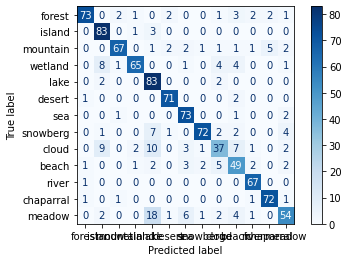

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=set(labelNames))
disp = disp.plot(cmap='Blues', values_format='d')

plt.show()

In [ ]:
#### write submission

outputTrain = root + 'Areal_train.predict'
outputValid = root + 'Areal_valid.predict'
outputTest = root + 'Areal_test.predict'

###Train data
with open(outputTrain, "w") as f:
  for idx in range(0, len(xTrain), 32):
    start = idx
    end = min(len(xTrain), idx+32)

    images = xTrain[start:end].reshape(((end-start),width, height, channels))
      
    outputs = model.predict(images)
    outputs = np.argmax(outputs, axis=1)

    for x in outputs:
      f.write(str(x.item())+'\n')


In [ ]:
#### load validation data
xVal = []

with open(valFeaturesFile) as f:

  data = f.readlines()

  for d in data:
    d = d.strip()
    d = [int(x) for x in d.split(' ')]
    d = np.array(d).reshape((height, width , channels))
    xVal.append(d)

xVal = np.array(xVal)


###Validation data
with open(outputValid, "w") as f:
  for idx in range(0, len(xVal), 32):
    start = idx
    end = min(len(xVal), idx+32)

    images = xVal[start:end].reshape(((end-start), width, height, channels))
      
    outputs = model.predict(images)
    outputs = np.argmax(outputs, axis=1)

    for x in outputs:
      f.write(str(x.item())+'\n')


In [ ]:
#### load test data
xTest = []

with open(testFeaturesFile) as f:

  data = f.readlines()

  for d in data:
    d = d.strip()
    d = [int(x) for x in d.split(' ')]
    d = np.array(d).reshape((height, width , channels))
    xTest.append(d)

xTest = np.array(xTest)

with open(outputTest, "w") as f:
  for idx in range(0, len(xTest), 32):
    start = idx
    end = min(len(xTest), idx+32)

    images = xTest[start:end].reshape(((end-start),width, height, channels))

    outputs = model.predict(images)
    outputs = np.argmax(outputs, axis=1)

    for x in outputs:
      f.write(str(x.item())+'\n')